In [2]:
# %matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [2]:
def bgr2rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [12]:
def save(img):
    cv2.imwrite("sus.png", img)

In [5]:
img = cv2.imread("imgs/misc/shadow1.png")

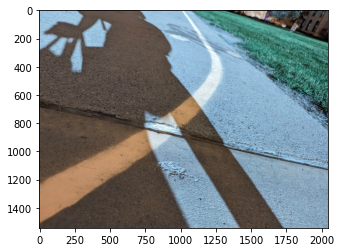

In [6]:
plt.imshow(img)
plt.show()

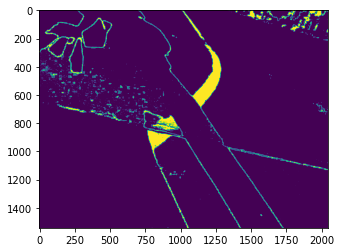

In [66]:
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
thresholded = ( (hsv[:,:,1]) / 255.0) < .13
plt.imshow(thresholded); plt.show()

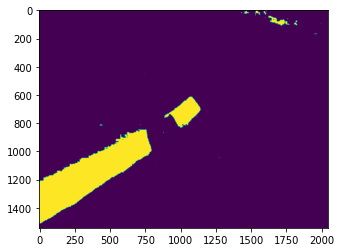

In [74]:
yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV).astype(np.float32)
thresholded = (yuv[:,:,1] / 255.0) > .55
plt.imshow(thresholded); plt.show()

In [26]:
img = cv2.imread("imgs/image_369.png")

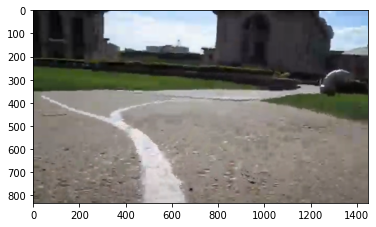

In [12]:
plt.imshow(bgr2rgb(img))
plt.show()

In [16]:
H,W,_ = img.shape
H,W

(833, 1448)

In [34]:
pts = [(H-1,0),(400,200),(400,1200),(H-1,W-1)]
for r,c in pts:
    cv2.circle(img, (c,r), radius=10, color=(0,255,0), thickness=-1)

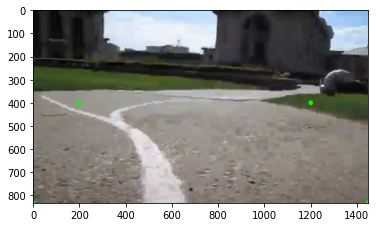

In [29]:
plt.imshow(bgr2rgb(img))
plt.show()

In [118]:
img_name = "checkerboard/ck6.jpg"
# img_name = "imgs/image_369.png"
img = bgr2rgb(cv2.imread(img_name))
H,W,_ = img.shape

In [119]:
resize=1
src = [(650,370), (370,370), (0,700), (1000,730)] 
src = [(int(resize*x),int(resize*y)) for x,y in src]
dst = [(10, 34), (-10, 34), (-10, 0), (10, 0)] # inches
dst = [(10*(x + 30), 10*y) for (x,y) in dst]
dst_np = np.array(dst, dtype=np.float32)
src_np = np.array(src, dtype=np.float32)
# resize,src_np, dst_np

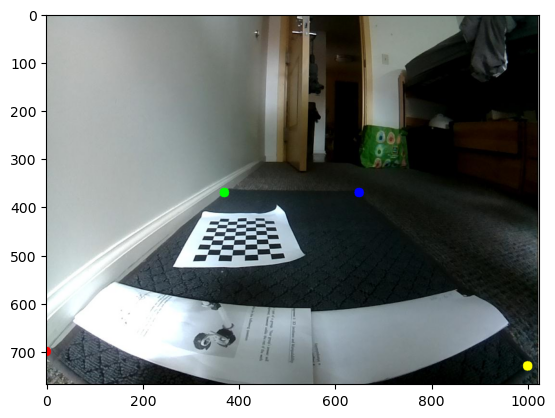

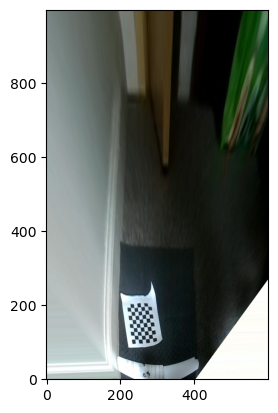

In [120]:
SCALE = 1000
colors = [
    (0, 0, 255),  # green
    (0, 255, 0),  # blue
    (255, 0, 0),  # red
    (255, 255, 0),  # yellow
]
for cnr_idx, (x, y) in enumerate(src):
    cv2.circle(img, (x, y), 10, colors[cnr_idx], -1)
plt.imshow(img)
plt.show()

img = bgr2rgb(cv2.imread(img_name))

M = cv2.getPerspectiveTransform(src_np, dst_np)
h, w = img.shape[:2]
warped = cv2.warpPerspective(img, M, (600, 1000), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
plt.imshow(warped, origin='lower')
plt.show()

In [24]:
yuv[:,:,0] / 255.0

array([[0.29411765, 0.29411765, 0.29411765, ..., 0.4       , 0.4       ,
        0.4       ],
       [0.31372549, 0.31372549, 0.31372549, ..., 0.4       , 0.4       ,
        0.4       ],
       [0.31764706, 0.31764706, 0.31764706, ..., 0.4       , 0.4       ,
        0.4       ],
       ...,
       [0.63529412, 0.64313725, 0.65490196, ..., 0.71764706, 0.71764706,
        0.71764706],
       [0.63921569, 0.64705882, 0.65882353, ..., 0.71764706, 0.71764706,
        0.71764706],
       [0.63921569, 0.65098039, 0.6627451 , ..., 0.71764706, 0.71764706,
        0.71764706]])

array([[0.19411765, 0.19411765, 0.19411765, ..., 0.3       , 0.3       ,
        0.3       ],
       [0.21372549, 0.21372549, 0.21372549, ..., 0.3       , 0.3       ,
        0.3       ],
       [0.21764706, 0.21764706, 0.21764706, ..., 0.3       , 0.3       ,
        0.3       ],
       ...,
       [0.53529412, 0.54313725, 0.55490196, ..., 0.61764706, 0.61764706,
        0.61764706],
       [0.53921569, 0.54705882, 0.55882353, ..., 0.61764706, 0.61764706,
        0.61764706],
       [0.53921569, 0.55098039, 0.5627451 , ..., 0.61764706, 0.61764706,
        0.61764706]])

In [126]:
yuv.dtype == np.float32

True

[[-0.45588234 -0.45588234 -0.45588234 ... -0.35       -0.35
  -0.35      ]
 [-0.4362745  -0.4362745  -0.4362745  ... -0.35       -0.35
  -0.35      ]
 [-0.43235293 -0.43235293 -0.43235293 ... -0.35       -0.35
  -0.35      ]
 ...
 [-0.11470586 -0.10686272 -0.09509802 ... -0.03235292 -0.03235292
  -0.03235292]
 [-0.11078429 -0.10294116 -0.09117645 ... -0.03235292 -0.03235292
  -0.03235292]
 [-0.11078429 -0.09901959 -0.08725488 ... -0.03235292 -0.03235292
  -0.03235292]]


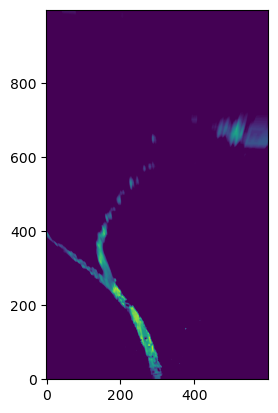

In [37]:
def relu(img, thresh):
    img = img.astype(np.float32)
    diff = img - thresh
    print(diff)
    relud = (diff * (diff > 0))
    return relud + thresh

yuv = cv2.cvtColor(warped, cv2.COLOR_RGB2YUV)
yuv_new = relu(yuv[:,:,0] / 255.0, .75)
plt.imshow(yuv_new, origin='lower')
plt.show()
yuv = yuv_new

In [128]:
(yuv.shape[1] // 20, yuv.shape[0] // 20)

(30, 50)

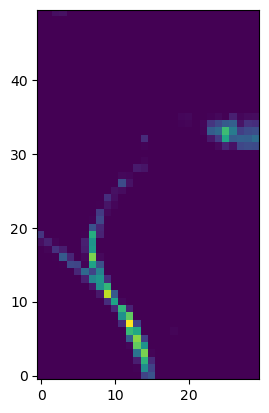

In [38]:
shape = (yuv.shape[1] // 20, yuv.shape[0] // 20)
resized = cv2.resize(yuv, shape, interpolation = cv2.INTER_AREA)
plt.imshow(resized, origin='lower')
plt.show()

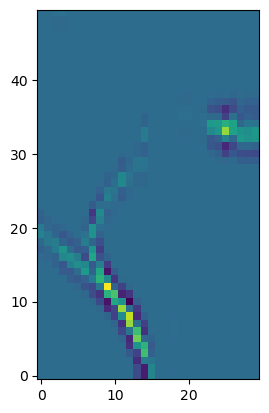

In [39]:
tophat = np.array([-1, -1, 2, 2, -1, -1])
conv = cv2.filter2D(src=resized, ddepth=-1, kernel=tophat)
plt.imshow(conv, origin='lower')
plt.show()

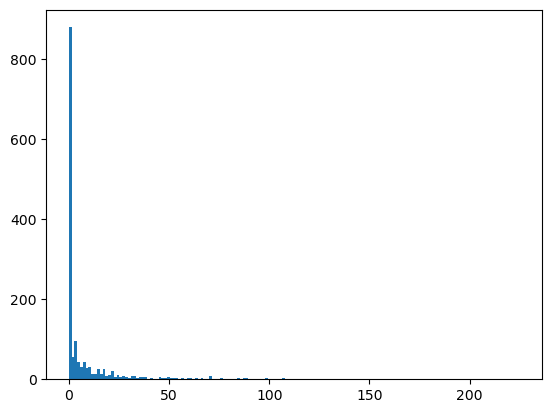

In [132]:
# hist, bin_edges = np.histogram(conv.flatten())
plt.hist(conv.flatten(), bins='auto')
plt.show()

In [134]:
avg = np.mean(conv)
avg

9.34

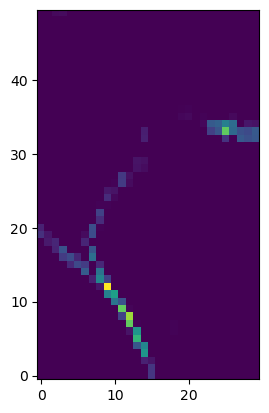

In [107]:
diff = conv.astype(np.float32)
relud = (diff * (diff > 0))
plt.imshow(relud, origin='lower')
plt.show()

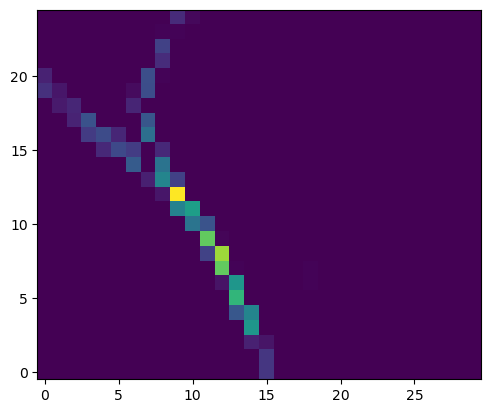

In [108]:
cropped = relud[:25,:]
plt.imshow(cropped, origin='lower')
plt.show()

In [109]:
c = cropped.reshape(-1)
indices = list(np.ndindex(cropped.shape[:]))
z = np.c_[indices, c]

In [110]:
# numpy.polyfit(x, y, deg, rcond=None, full=False, w=None, cov=False)
z = np.polyfit(x=z[:,0],y=z[:,1],w=z[:,2], deg=2)
z

array([ 8.73547881e-03, -7.66406428e-01,  1.68633905e+01])

In [76]:
np.poly1d(z)

poly1d([ 8.73547881e-03, -7.66406428e-01,  1.68633905e+01])

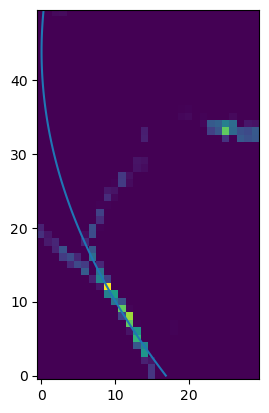

In [117]:
new = relud.copy()
xp = np.linspace(0,50, 100)
_ = plt.plot(p(xp),xp)
plt.imshow(new, origin='lower')
plt.show()

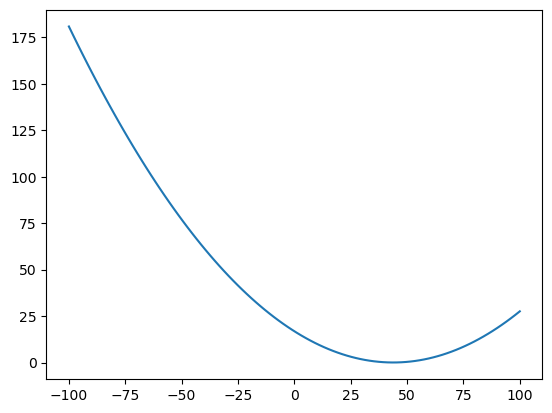

In [85]:
import matplotlib.pyplot as plt
p = np.poly1d(z)
xp = np.linspace(-100,100, 100)
_ = plt.plot(xp, p(xp))
plt.show()

In [68]:
# from time import sleep
# from picamera import PiCamera

# camera = PiCamera()
# camera.resolution = [1024, 768]
# camera.start_preview()

# sleep(2)

# camera.capture('foo.jpg')
# camera.close()

In [11]:
import cv2
import numpy as np
import os
import glob
CHECKERBOARD = (6,9)
subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_FIX_SKEW
objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
_img_shape = None
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('checkerboard/*.jpg')
for fname in images:
    img = cv2.imread(fname)
    if _img_shape == None:
        _img_shape = img.shape[:2]
    else:
        assert _img_shape == img.shape[:2], "All images must share the same size."
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),subpix_criteria)
        imgpoints.append(corners)
N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
rms, _, _, _, _ = \
    cv2.fisheye.calibrate(
        objpoints,
        imgpoints,
        gray.shape[::-1],
        K,
        D,
        rvecs,
        tvecs,
        calibration_flags,
        (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    )
print("Found " + str(N_OK) + " valid images for calibration")
print("DIM=" + str(_img_shape[::-1]))
print("K=np.array(" + str(K.tolist()) + ")")
print("D=np.array(" + str(D.tolist()) + ")")

Found 3 valid images for calibration
DIM=(1024, 768)
K=np.array([[465.2204776706876, 0.0, 520.6063573966712], [0.0, 464.00154309364046, 327.28279417219517], [0.0, 0.0, 1.0]])
D=np.array([[0.10872294377145097], [1.162022223507608], [-7.00997452733623], [8.771499066792968]])


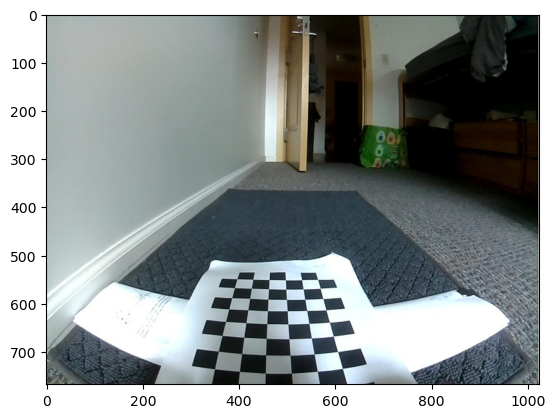

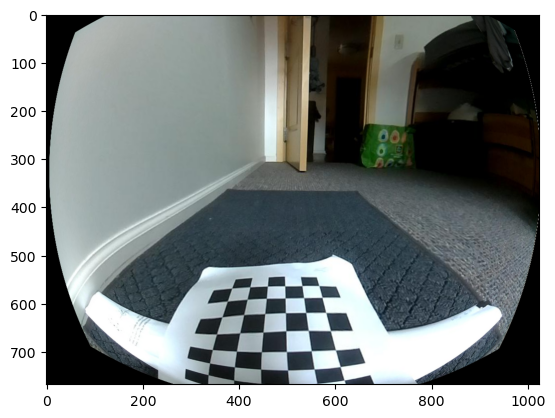

In [66]:
# You should replace these 3 lines with the output in calibration step
DIM=(1024, 768)
K=np.array([[465.2204776706876, 0.0, 520.6063573966712], [0.0, 464.00154309364046, 327.28279417219517], [0.0, 0.0, 1.0]])
K_new = np.array([[465.2204776706876, 0.0, 520.6063573966712], [0.0, 464.00154309364046, 327.28279417219517], [0.0, 0.0, 1.0]])

D=np.array([[0.10872294377145097], [1.162022223507608], [-7.00997452733623], [8.771499066792968]])
def undistort(img_path):
    plt.imshow(bgr2rgb(cv2.imread(img_path)))
    plt.show()
    img = cv2.imread(img_path)
    h,w = img.shape[:2]
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K_new, DIM, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    plt.imshow(bgr2rgb(undistorted_img))
    plt.show()

undistort('checkerboard/ck1.jpg')

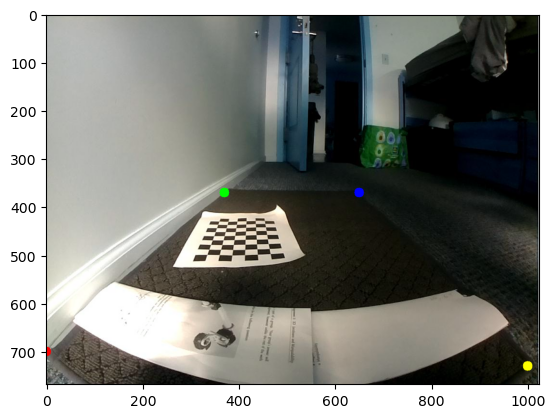

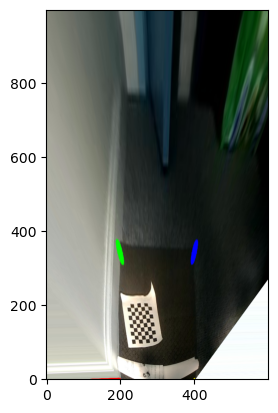

In [21]:
# assume img is 1024 x 768
img = cv2.imread('imgs/04.jpg')

# order: tr, tl, bl, br
src = [(650,370), (370,370), (0,700), (1000,730)] 
dst = [(10, 34), (-10, 34), (-10, 0), (10, 0)]
dst = [(10*(x + 30), 10*y) for (x,y) in dst]
src_np = np.array(src, dtype=np.float32)
dst_np = np.array(dst, dtype=np.float32)

colors = [
    (0, 0, 255),  # green
    (0, 255, 0),  # blue
    (255, 0, 0),  # red
    (255, 255, 0),  # yellow
]
for cnr_idx, (x, y) in enumerate(src):
    cv2.circle(img, (x, y), 10, colors[cnr_idx], -1)
plt.imshow(img)
plt.show()


# inverse projective map
M = cv2.getPerspectiveTransform(src_np, dst_np)
warped = cv2.warpPerspective(img, M, (600, 1000), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

plt.imshow(warped, origin='lower')
plt.show()

In [51]:
curve

array([[ 19,   0],
       [ 18,   0],
       [ 17,   1],
       [ 17,   1],
       [ 16,   2],
       [ 15,   2],
       [ 15,   3],
       [ 14,   3],
       [ 13,   4],
       [ 13,   4],
       [ 12,   5],
       [ 12,   5],
       [ 11,   6],
       [ 11,   6],
       [ 11,   7],
       [ 10,   7],
       [ 10,   8],
       [ 10,   8],
       [ 10,   9],
       [  9,   9],
       [  9,  10],
       [  9,  10],
       [  9,  11],
       [  9,  11],
       [  9,  12],
       [  9,  12],
       [  9,  13],
       [  9,  13],
       [  9,  14],
       [  9,  14],
       [ 10,  15],
       [ 10,  15],
       [ 10,  16],
       [ 10,  16],
       [ 11,  17],
       [ 11,  17],
       [ 11,  18],
       [ 12,  18],
       [ 12,  19],
       [ 13,  19],
       [ 13,  20],
       [ 14,  20],
       [ 15,  21],
       [ 15,  21],
       [ 16,  22],
       [ 17,  22],
       [ 17,  23],
       [ 18,  23],
       [ 19,  24],
       [ 20,  24],
       [ 21,  25],
       [ 22,  25],
       [ 23,

In [86]:
def is_peak(arr, i):
    if i == 0 or i == len(arr) - 1:
        return False
    return arr[i] > .08 and arr[i-1] < .9*arr[i] and arr[i+1] < .9*arr[i]

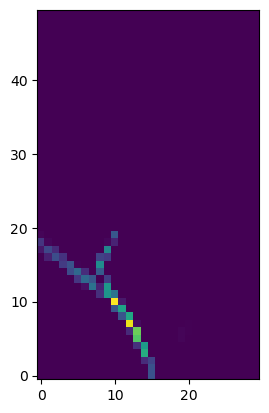

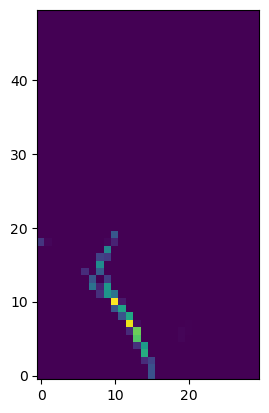

In [107]:
arr = relud.copy()
left_to_right = False
for i in range(arr.shape[0]):
    is_peaked = 0
    for j in range(arr.shape[1]):
        if not left_to_right:
            j = arr.shape[1] - j - 1
        if is_peaked or is_peak(arr[i], j):
            is_peaked += 1
        if is_peaked > 3:
            arr[i][j] = 0

plt.imshow(relud, origin='lower')
plt.show()
plt.imshow(arr, origin='lower')
plt.show() 

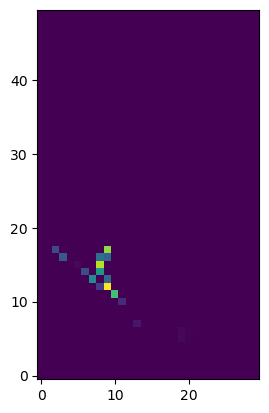

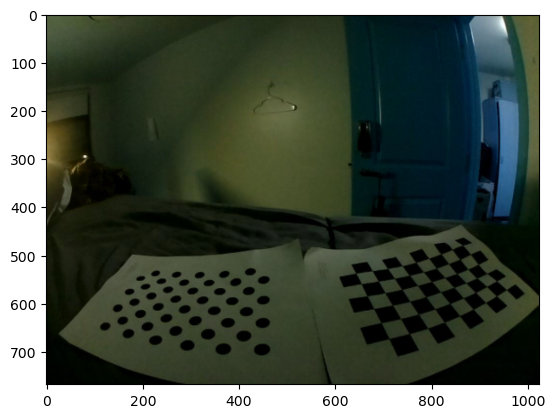

(768, 1024, 3)

In [123]:
img = cv2.imread('imgs/05.png')
img = cv2.resize(img, (1024,768), interpolation = cv2.INTER_AREA)
plt.imshow(img)
plt.show()
img.shape

In [128]:
img.shape[1] / img.shape[0]

1.3447432762836187

In [152]:
img = cv2.imread('imgs/04.jpg')

# assume img is 1024 x 768
assert math.isclose(1024 / 768, img.shape[1] / img.shape[0], rel_tol=.1)

resize = img.shape[1] / 1024

# order: tr, tl, bl, br
src = [(650,370), (370,370), (0,700), (1000,730)]
src = [(int(resize*x), int(resize*y)) for (x,y) in src]
dst = [(10, 34), (-10, 34), (-10, 0), (10, 0)]
dst = [(int(10*(x + 30)), int(10*y)) for (x,y) in dst]

src_np = np.array(src, dtype=np.float32)
dst_np = np.array(dst, dtype=np.float32)

# colors = [
#     (0, 0, 255),  # green
#     (0, 255, 0),  # blue
#     (255, 0, 0),  # red
#     (255, 255, 0),  # yellow
# ]
# for cnr_idx, (x, y) in enumerate(src):
#     cv2.circle(img, (x, y), 10, colors[cnr_idx], -1)

# inverse projective map
M = cv2.getPerspectiveTransform(src_np, dst_np)
warped2 = cv2.warpPerspective(img, M, (600, 1000), flags=cv2.INTER_LINEAR)
warped = cv2.warpPerspective(img, M, (600, 1000), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

# threshold in yuv space
yuv = cv2.cvtColor(warped, cv2.COLOR_BGR2YUV)
yuv = yuvd[:,:,0] / 255.0
yuv_relu = relu(yuv, .7)

# resize image to (30,50), then crop to (30,20)
resized = cv2.resize(yuv_relu, (30,50), interpolation = cv2.INTER_AREA)
resized = resized[:20,:]

# tophat convolve
tophat = np.array([-1, -1, 2, 2, -1, -1])
conv = cv2.filter2D(src=resized, ddepth=-1, kernel=tophat)

# relu out negative response from kernel
relud = relu(conv, 0)

# fit a quadratic
flattened = relud.reshape(-1)
indices = list(np.ndindex(relud.shape[:]))
pts = np.c_[indices, flattened]

coeffs = np.polyfit(x=pts[:,0],y=pts[:,1],w=pts[:,2], deg=2)
poly = np.poly1d(coeffs)

yp = np.linspace(0,30,100) # 100 pts between (0,30)
xp = poly(yp)

xp = 20 * xp
yp = 20 * yp

curve = np.column_stack((xp.astype(np.int32), yp.astype(np.int32)))
cv2.polylines(warped2, [curve], False, (0,255,255), thickness=2)

# compute curvilinear position and curvature at 0
# self.offset = poly(0)
a,b,c = coeffs
# self.curv = (1 + b ** 2) ** 1.5 / abs(2*a)

cv2.flip(np.hstack((warped2,yuvd,)), 0)

array([[[132, 134, 122],
        [132, 134, 122],
        [131, 133, 121],
        ...,
        [106, 117, 105],
        [107, 117, 104],
        [111, 117, 104]],

       [[132, 134, 122],
        [132, 134, 122],
        [131, 133, 121],
        ...,
        [108, 117, 105],
        [110, 117, 104],
        [113, 117, 104]],

       [[132, 134, 122],
        [132, 134, 122],
        [132, 134, 122],
        ...,
        [109, 117, 105],
        [112, 117, 104],
        [115, 117, 104]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [251, 126, 128],
        [250, 126, 128],
        [250, 126, 128]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [255, 127, 128],
        [255, 127, 128],
        [255, 127, 128]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [251, 128, 128],
        [252, 128, 128],
        [252, 128, 128]]

In [153]:
warped2.shape, yuvd.shape

((1000, 600, 3), (1000, 600, 3))

In [139]:
pts

array([[ 0.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  2.,  0.],
       ...,
       [19., 27.,  0.],
       [19., 28.,  0.],
       [19., 29.,  0.]])

In [131]:
a,b,c=coeffs

In [132]:
a,b,c

(-6.6149355664263364e-15, -4.050804204783236e-15, 19.92452830188732)

In [130]:
poly(0)

19.92452830188732

In [110]:
20 * curve

array([[ 6660,     0],
       [ 6520,   200],
       [ 6360,   400],
       [ 6220,   600],
       [ 6060,   800],
       [ 5920,  1000],
       [ 5780,  1200],
       [ 5640,  1400],
       [ 5500,  1600],
       [ 5360,  1800],
       [ 5220,  2020],
       [ 5080,  2220],
       [ 4940,  2420],
       [ 4820,  2620],
       [ 4680,  2820],
       [ 4540,  3020],
       [ 4420,  3220],
       [ 4300,  3420],
       [ 4160,  3620],
       [ 4040,  3820],
       [ 3920,  4040],
       [ 3800,  4240],
       [ 3680,  4440],
       [ 3560,  4640],
       [ 3440,  4840],
       [ 3320,  5040],
       [ 3220,  5240],
       [ 3100,  5440],
       [ 2980,  5640],
       [ 2880,  5840],
       [ 2780,  6060],
       [ 2660,  6260],
       [ 2560,  6460],
       [ 2460,  6660],
       [ 2360,  6860],
       [ 2260,  7060],
       [ 2160,  7260],
       [ 2060,  7460],
       [ 1960,  7660],
       [ 1860,  7860],
       [ 1780,  8080],
       [ 1680,  8280],
       [ 1600,  8480],
       [ 15

In [61]:
curve = np.column_stack((xp.astype(np.int32) * 20, yp.astype(np.int32)) * 20)

In [57]:
xp

array([ 19.47529241,  18.65815336,  17.87572349,  17.1280028 ,
        16.41499131,  15.73668899,  15.09309586,  14.48421191,
        13.91003715,  13.37057158,  12.86581518,  12.39576798,
        11.96042995,  11.55980111,  11.19388146,  10.86267099,
        10.56616971,  10.30437761,  10.07729469,   9.88492096,
         9.72725641,   9.60430105,   9.51605487,   9.46251788,
         9.44369007,   9.45957145,   9.51016201,   9.59546175,
         9.71547068,   9.8701888 ,  10.05961609,  10.28375258,
        10.54259825,  10.8361531 ,  11.16441714,  11.52739036,
        11.92507276,  12.35746435,  12.82456513,  13.32637509,
        13.86289423,  14.43412256,  15.04006007,  15.68070677,
        16.35606265,  17.06612772,  17.81090197,  18.59038541,
        19.40457803,  20.25347983,  21.13709082,  22.055411  ,
        23.00844036,  23.9961789 ,  25.01862663,  26.07578354,
        27.16764964,  28.29422492,  29.45550938,  30.65150303,
        31.88220587,  33.14761789,  34.44773909,  35.78

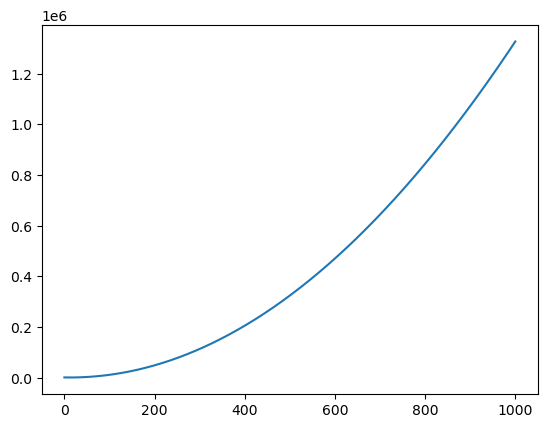

In [48]:
plt.plot(yp,xp)

In [39]:
color = cv2.merge((relud,relud,relud))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


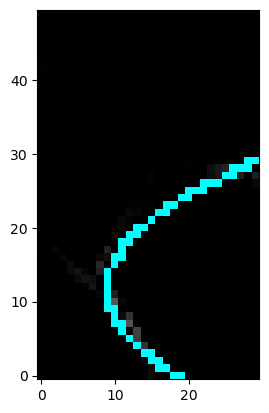

In [40]:
curve = np.column_stack((yp.astype(np.int32), xp.astype(np.int32)))
cv2.polylines(color, [curve], False, (0,255,255))
plt.imshow(color, origin='lower')
plt.show()

In [49]:
coeffs

array([ 0.06803694, -1.65229742, 19.47529241])

In [42]:
warped.shape

(1000, 600, 3)